In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

Let us start by importing the data and exploring the column names and number of entries.

In [2]:
df_checkin = pd.read_csv("data/foursquare_checkin_data.csv.zip", compression='zip')

In [3]:
df_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22809624 entries, 0 to 22809623
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   User_ID     int64  
 1   Venue_ID    object 
 2   day         object 
 3   local_time  object 
 4   lat         float64
 5   lon         float64
 6   place       object 
 7   country     object 
dtypes: float64(2), int64(1), object(5)
memory usage: 1.4+ GB


### Ground Truth

Let us create a ground truth dataframe that will contain the homes of users.

We start by isolating the check-ins that have the `Home (private)` label.

In [4]:
df_checkins_homes = df_checkin[df_checkin.place == "Home (private)"]

In [5]:
len(df_checkins_homes)

1724007

We see that we have 1724007 user check-ins into their homes.

There is one issue with the dataset, whch is that the home location may vary certain users. Here, we sort the home check-ins by `User ID` and we see that for user 15, the home longitude and latitude may vary.

In [6]:
df_checkins_homes.sort_values("User_ID").head(30)

,User_ID,Venue_ID,day,local_time,lat,lon,place,country
5669330,15,4f9043f2e4b06b50af9c407c,Mon,2012-06-11 01:26:11+00:00,36.289471,-119.342457,Home (private),US
2314342,15,4f9043f2e4b06b50af9c407c,Sat,2012-04-28 13:03:24+00:00,36.289471,-119.342457,Home (private),US
2314343,15,4f9043f2e4b06b50af9c407c,Sun,2012-04-29 11:05:04+00:00,36.289471,-119.342457,Home (private),US
2314344,15,4f9043f2e4b06b50af9c407c,Wed,2012-05-01 23:53:56+00:00,36.289471,-119.342457,Home (private),US
4407361,15,4bcb40170687ef3b2349ddcc,Wed,2012-05-23 16:16:55+00:00,36.298218,-119.272754,Home (private),US
4693116,15,4f9043f2e4b06b50af9c407c,Tue,2012-05-29 13:26:33+00:00,36.289471,-119.342457,Home (private),US
2747619,15,4f9043f2e4b06b50af9c407c,Mon,2012-05-06 23:37:41+00:00,36.289471,-119.342457,Home (private),US
4693115,15,4f9043f2e4b06b50af9c407c,Tue,2012-05-29 00:16:37+00:00,36.289471,-119.342457,Home (private),US
4693114,15,4f9043f2e4b06b50af9c407c,Mon,2012-05-28 00:35:05+00:00,36.289471,-119.342457,Home (private),US
4693113,15,4f9043f2e4b06b50af9c407c,Sun,2012-05-27 10:43:29+00:00,36.289471,-119.342457,Home (private),US


Create dataframe for user home locations, where we use the median location with label home for each user

Since the check-in location labeled with `Home (private)` may not be unique for a certain user, we decide to keep only users whose home locations have a standard deviation of 100m around the mean location.

The `haversine` function computes the distance between two point on a sphere using thei longitudes and latitudes.

In [7]:
EARTH_RADIUS = 6371.0088
def haversine(lat1, lat2, lon1, lon2):
    sigma = np.arcsin(np.sqrt(np.sin((lat2-lat1)/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin((lon1-lon2)/2)**2))
    return round(2 * EARTH_RADIUS * sigma)

The `select_relevant_homes` filters out the users having home locations with a standard deviation larger than 100m.

In [8]:
def select_relevant_homes(df_homes):

    # Grouping df_homes according to the user id and compute std and mean for lat and lon
    df_homes = df_homes.groupby('User_ID').agg({'lat':('std','mean'), 'lon':('std','mean')})
    
    # Filling nan values with 0 (std return 0 if there is only one sample)
    df_homes.fillna(0, inplace=True)
    
    # Compute distance from mean
    
    # Preparing dataframe
    df_tmp = pd.DataFrame()
    df_tmp['lat1'] = df_homes.lat['mean'] - df_homes.lat['std']
    df_tmp['lat2'] = df_homes.lat['mean'] + df_homes.lat['std']
    df_tmp['lon1'] = df_homes.lon['mean'] - df_homes.lon['std']
    df_tmp['lon2'] = df_homes.lon['mean'] + df_homes.lon['std']
    
    # Compute distance
    df_tmp['home_radius'] = haversine(df_tmp.lat1, df_tmp.lat2, df_tmp.lon1, df_tmp.lon2)
    
    # Filter home and keep relevant home (estimated distance between homes checkins < 100m )
    df_homes = df_homes[df_tmp['home_radius']<0.1][[('lat', 'mean'), ('lon', 'mean')]].copy()
    
    df_homes.columns = df_homes.columns.get_level_values(0)
    
    return df_homes

We decided to only keep the users whose home location is in the United States.

In [9]:
df_homes = select_relevant_homes(df_checkins_homes[df_checkins_homes.country == 'US'].copy())

In [10]:
df_homes

,lat,lon
User_ID,,
19,40.980988,-72.123841
58,29.933542,-90.098043
256,36.958127,-121.987122
277,45.425242,-122.553632
283,37.706045,-122.463708
...,...,...
2162078,39.904579,-75.323726
2163103,39.661642,-104.839625
2166514,28.480089,-81.455364


Now we are left with 4633 users along with their home locations.

### Home locations using discretization

Now let us isolate the users that have homes.

In [12]:
users_with_homes = df_homes.index.values

In [13]:
df_checkin_filtered = df_checkin[df_checkin["User_ID"].isin(users_with_homes)].copy()

Here is the code to discretize the world and detect home locations (from P2).

In [14]:
import math
from pandarallel import pandarallel

# Initialization
pandarallel.initialize()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [15]:
# Function to be called in lambda to get specific 25km*25km square where the coordinates are
def square_coordinate(latitude, longitude):
    lat_rad = np.deg2rad(latitude)
    lon_rad = np.deg2rad(longitude)
    
    square_side_on_equator = 10

    # signed distance from equator
    latitude_dist = EARTH_RADIUS * lat_rad

    # signed distance from prime meridian (moving parallel to equator parallel to equator)
    longitude_dist = EARTH_RADIUS * np.cos(lat_rad) * lon_rad

    latitude_square_nbr = np.trunc(latitude_dist / square_side_on_equator)
    
    # rescaling the length of the square side because of the curvature of the earth.
    # on a cylindrical projection, horizontal distances are rescaled as follows
    square_side_on_lat_line = square_side_on_equator * np.cos(lat_rad)

    longitude_square_nbr = np.trunc(longitude_dist / square_side_on_lat_line)

    return list(zip(latitude_square_nbr, longitude_square_nbr))

In [16]:
def get_home_coordinates(df):
    df_ = df.copy()

    # Get the square coordinates for each row
    df_['square_coordinates'] = square_coordinate(df_.lat.values, df_.lon.values)
    
    # Group by user then square, for each square create a list of the corresponding coordinates
    df_ = df_.groupby(['User_ID', 'square_coordinates'], as_index=False)\
                     [['User_ID', 'square_coordinates', 'lat', 'lon']].agg(list)
    
    # Compute number of checkins in each square per user
    df_['freq'] = df_['lat'].str.len()
    
    # Keep only the most frequented square for each user
    df_ = df_.sort_values(['User_ID','freq'], ascending=[True, False]).drop_duplicates(['User_ID'])
    
    # For each user, find the average location in the most frequented square
    df_['lat'] = df_.lat.parallel_apply(lambda row: np.mean(row))
    df_['lon'] = df_.lon.parallel_apply(lambda row: np.mean(row))
    
    #return a dataframe with user, home latitude and home longitude
    return df_[['User_ID', 'lat', 'lon']].set_index('User_ID')

Let us now copute the home location of the users using the discretization.

In [17]:
df_detected_homes = get_home_coordinates(df_checkin_filtered)

In [18]:
df_detected_homes

,lat,lon
User_ID,,
19,40.724158,-73.988653
58,40.695894,-73.986256
256,33.947396,-116.982608
277,45.433243,-122.552361
283,37.733366,-122.453535
...,...,...
2162078,39.906446,-75.326858
2163103,39.704853,-104.997804
2166514,28.472556,-81.462514


### Comparizon between ground truth and discretization results

Let us compute the distance between the home locations resulting from the discretization and the true home locations.

First, we merge the two dataframes, then we compute the distance between the true home and the detected home using the `haversine` function defined above.

In [20]:
df_distance_detection_from_truth = pd.merge(df_homes, df_detected_homes, left_index=True, right_index=True)

In [21]:
df_distance_detection_from_truth

,lat_x,lon_x,lat_y,lon_y
User_ID,,,,
19,40.980988,-72.123841,40.724158,-73.988653
58,29.933542,-90.098043,40.695894,-73.986256
256,36.958127,-121.987122,33.947396,-116.982608
277,45.425242,-122.553632,45.433243,-122.552361
283,37.706045,-122.463708,37.733366,-122.453535
...,...,...,...,...
2162078,39.904579,-75.323726,39.906446,-75.326858
2163103,39.661642,-104.839625,39.704853,-104.997804
2166514,28.480089,-81.455364,28.472556,-81.462514


In [22]:
df_distance_detection_from_truth['dist'] = haversine(df_distance_detection_from_truth.lat_x,
                                                     df_distance_detection_from_truth.lat_y,
                                                     df_distance_detection_from_truth.lon_x,
                                                     df_distance_detection_from_truth.lon_y)

In [23]:
df_distance_detection_from_truth

,lat_x,lon_x,lat_y,lon_y,dist
User_ID,,,,,
19,40.980988,-72.123841,40.724158,-73.988653,11957.0
58,29.933542,-90.098043,40.695894,-73.986256,10412.0
256,36.958127,-121.987122,33.947396,-116.982608,13801.0
277,45.425242,-122.553632,45.433243,-122.552361,51.0
283,37.706045,-122.463708,37.733366,-122.453535,186.0
...,...,...,...,...,...
2162078,39.904579,-75.323726,39.906446,-75.326858,17.0
2163103,39.661642,-104.839625,39.704853,-104.997804,489.0
2166514,28.480089,-81.455364,28.472556,-81.462514,66.0


Now, we visualize the distribution of distances. We plot the distribution of distances on a log-log scale.

In [24]:
def power_func(x, a, b):
    """
    function to compute a*(x^b)
    """
    return a * np.power(x, b)

In [58]:
def density_loglog_dist_plot(series, fit_line=False):
    fig = plt.figure()
    array = plt.hist(series, bins=1000, log=True, density=True, bottom=0, histtype='step')
    plt.close(fig)

    plt.loglog(array[1][1:], array[0], alpha=0.5, label='Distance from home probability density')
    
    if fit_line:
        start = 4

        distribution = array[0][start:]
        distances = array[1][start+1:]

        [a, b], _ = curve_fit(power_func, distances, distribution)

        x = range(round(distances[0]), round(distances[-1]))
        y = power_func(x, a, b)

        plt.loglog(x, y, color='r', label=r'$%.4f*x^{%.4f}$' % (a,b))
    
    plt.ylim(1e-6, 1e-2)
    plt.xlim(10, 5*1e4)
    
    plt.ylabel("Probability density", fontsize=12)
    plt.xlabel("Distance from true home (km)", fontsize=12)

    plt.title("Probability distribution\nof the distance between the detected\nhome and the actual home\n",
              fontsize=18)

    plt.legend()

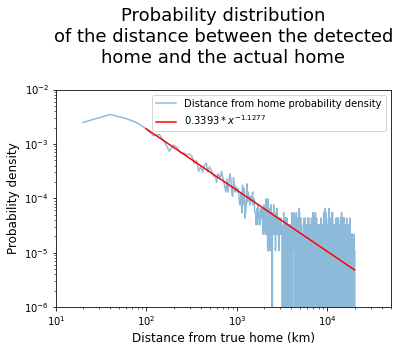

In [59]:
density_loglog_dist_plot(df_distance_detection_from_truth.dist, fit_line=True)

We see that the distribution of distances follows a power law that can be approximated by $0.3393x ^{-1.2277}$. This means that there are users whose predicted home location is far by orders of magnitude from the original actual home location.

Let us explore the distribution of distances a bit further by seeing its mean, standard deviation, and its 10-percentiles.

In [27]:
df_distance_detection_from_truth.dist.describe(np.array(range(1,10))/10).to_frame()

,dist
count,4633.000000
mean,2856.772286
std,4715.070206
min,0.000000
10%,34.000000
20%,68.000000
30%,124.600000
40%,227.000000
50%,430.000000
60%,817.000000


We see that only less than 10% of distances are less than 34km and we need a tolerance of more than 5427km to have an accuracy higher than 80%.

Let us go a bit further by plotting the culuative distribution of distances.

In [28]:
def cumulative_dist_plot(series):
    fig = plt.figure()
    array = plt.hist(series, bins=1000, density=True, cumulative=True, bottom=0, histtype='step')
    plt.close(fig)
    
    x = array[1][1:]
    y = array[0]
    
    plt.plot(x, y, alpha=0.8, label='Distance from home CDF')
    
    percentage = 0.85
    
    percentile = np.percentile(series, 85)
    
    plt.plot([10, percentile], [percentage, percentage], color='g', linestyle='dotted')
    plt.plot([percentile, percentile], [0, percentage], color='g', linestyle='dotted')
    
    plt.xscale('log')
    plt.xlim(10, 5*1e4)
    plt.ylim(0, 1.1)
    
    plt.yticks(sorted(list(plt.yticks()[0]) + [percentage])[:-1])
    
    plt.annotate(f'{percentile:.0f} km', (percentile, 0), xytext=(percentile+1000, 0.12),
                 arrowprops={'width':1, 'headlength':10, 'headwidth':5})
    
    plt.ylabel("Cumulative density", fontsize=12)
    plt.xlabel("Distance from true home (km)", fontsize=12)

    plt.title("Cumulative distribution\nof the distance between the detected\nhome and the actual home\n",
              fontsize=18)

    plt.legend()

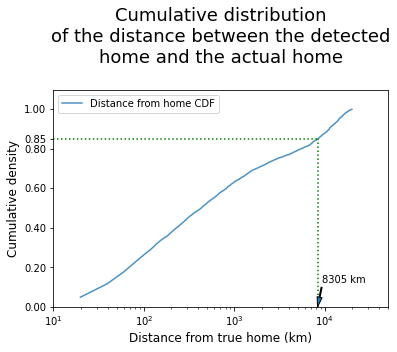

In [29]:
cumulative_dist_plot(df_distance_detection_from_truth.dist)

We see that to attain an accuracy of 85%, we need to consider detected home locations to be true up to a distance of
8'305 km from the true home location. This distance is more than two times the length of the Mediterranean Sea.

Therefore, we conclude that the method proposed by the paper does not generalize well to our proposed dataset. Therefore, we explore machine learning techniques to find home locations of users based on their check-ins.

### Proposed model testing

The Machine Learning based method we propose is deeply described in separate notebooks (see to the README file). Here, we only test for its performance and compare it to the method proposed by the paper.

Let us start by importing the model and load pre-prepared data for prediction.

In [30]:
import joblib

from keras.models import load_model
from metrics import f1_m

In [31]:
scaler = joblib.load('models/scaler.pkl')

#clf_svc = joblib.load('models/SVC.pkl')

NN_model = load_model('models/NN_clf.h5', custom_objects={'f1_m': f1_m})

In [32]:
df_features = pd.read_csv('data/training_dataset.csv', index_col = 0)

Here we extract the needed features for the ML prediction.

In [35]:
def get_X(df, scaler):
    X = df[['CR','MR','EDR','EIDR','PR','RPR']].values

    X = scaler.transform(X)

    return X

In [36]:
features = get_X(df_features, scaler)

Now, we use the model to predict whether a location is a home location.

In [37]:
prediction = NN_model.predict(features).flatten() > 0.5

In [38]:
df_features['prediction'] = prediction

Now we keep the locations that were predicted as homes. We also discard the users that have two predicted homes.

In [40]:
df_features_filtered = df_features[df_features.prediction == True][['user', 'lat', 'lon']]

In [41]:
df_features_filtered = df_features_filtered.drop_duplicates('user', keep=False)

In [53]:
df_features_filtered.head()

,user,lat,lon
0,19,38.652989,-73.973113
8,58,39.007991,-87.881967
10,190,-18.208942,-42.529624
58,277,45.425242,-122.553632
91,283,38.379869,-115.579788


Now, let us move to the testing. We first merge the prediction dataframe with the "ground truth" dataframe. Then we copute the distances between the true location and the predicted location.

In [54]:
df_distance_prediction_from_truth = pd.merge(df_homes, df_features_filtered, left_index=True, right_on='user')

In [55]:
df_distance_prediction_from_truth.head()

,lat_x,lon_x,user,lat_y,lon_y
0,40.980988,-72.123841,19,38.652989,-73.973113
8,29.933542,-90.098043,58,39.007991,-87.881967
58,45.425242,-122.553632,277,45.425242,-122.553632
91,37.706045,-122.463708,283,38.379869,-115.579788
96,42.995416,-87.899151,319,41.744665,-90.436247


In [56]:
df_distance_prediction_from_truth['dist'] = haversine(df_distance_prediction_from_truth.lat_x,
                                                      df_distance_prediction_from_truth.lat_y,
                                                      df_distance_prediction_from_truth.lon_x,
                                                      df_distance_prediction_from_truth.lon_y)

In [57]:
df_distance_prediction_from_truth.head()


,lat_x,lon_x,user,lat_y,lon_y,dist
0,40.980988,-72.123841,19,38.652989,-73.973113,9731.0
8,29.933542,-90.098043,58,39.007991,-87.881967,18613.0
58,45.425242,-122.553632,277,45.425242,-122.553632,0.0
91,37.706045,-122.463708,283,38.379869,-115.579788,5538.0
96,42.995416,-87.899151,319,41.744665,-90.436247,2289.0


Here, we plot the log-log distribution of the distances.

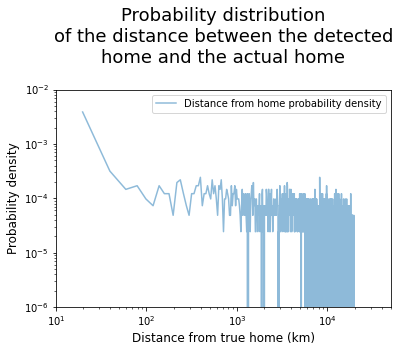

In [60]:
density_loglog_dist_plot(df_distance_detection_from_truth2.dist)

We see that our model does not perform as expected. Indeed, we see that our model underperforms the method proposed in the paper.

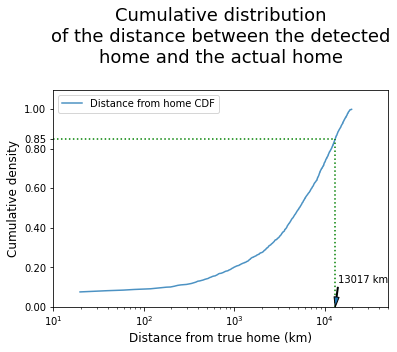

In [52]:
cumulative_dist_plot(df_distance_detection_from_truth2.dist)

In fact, we see that to attain an accuracy of 85%, we need to consider detected home locations to be true up to a distance of
13'017 km from the true home location, which is larger than the 8'305 km we found when testing the method proposed in the paper.